<a href="https://colab.research.google.com/github/Fu-Pei-Yin/Deep-Generative-Mode/blob/week2/VAE%E5%9C%A8%E6%89%8B%E5%AF%AB%E6%95%B8%E5%AD%97%E4%B8%8A%E7%9A%84%E6%87%89%E7%94%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/80, Loss: 165.6817
Epoch 2/80, Loss: 121.8054
Epoch 3/80, Loss: 114.8626
Epoch 4/80, Loss: 111.9616
Epoch 5/80, Loss: 110.1205
Epoch 6/80, Loss: 108.9645
Epoch 7/80, Loss: 108.1110
Epoch 8/80, Loss: 107.4610
Epoch 9/80, Loss: 106.8871
Epoch 10/80, Loss: 106.4715
Epoch 11/80, Loss: 106.1059
Epoch 12/80, Loss: 105.7801
Epoch 13/80, Loss: 105.5475
Epoch 14/80, Loss: 105.2672
Epoch 15/80, Loss: 105.0512
Epoch 16/80, Loss: 104.8593
Epoch 17/80, Loss: 104.6260
Epoch 18/80, Loss: 104.4972
Epoch 19/80, Loss: 104.3295
Epoch 20/80, Loss: 104.2407
Epoch 21/80, Loss: 104.0871
Epoch 22/80, Loss: 103.9238
Epoch 23/80, Loss: 103.7849
Epoch 24/80, Loss: 103.7048
Epoch 25/80, Loss: 103.5804
Epoch 26/80, Loss: 103.4759
Epoch 27/80, Loss: 103.4056
Epoch 28/80, Loss: 103.2898
Epoch 29/80, Loss: 103.1843
Epoch 30/80, Loss: 103.1419
Epoch 31/80, Loss: 103.0212
Epoch 32/80, Loss: 102.9654
Epoch 33/80, Loss: 102.8569
Epoch 34/80, Loss: 102.8072
Epoch 35/80, Loss: 102.7502
Epoch 36/80, Loss: 102.6152
E

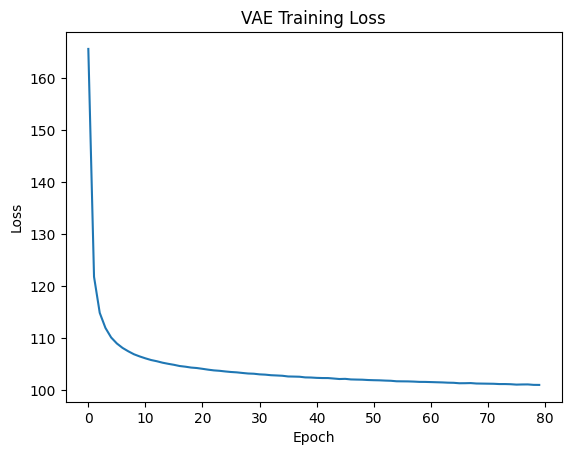

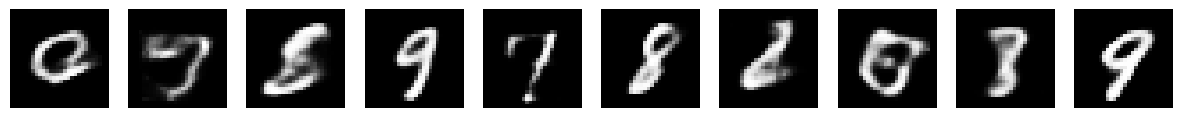

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 固定随机种子
torch.manual_seed(42)

# 设备配置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 超参数
batch_size = 128
lr = 1e-3
epochs = 80
latent_dim = 20
input_dim = 28 * 28
hidden_dim = 400

# 数据加载与预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # 展平为 784
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 定义 VAE 模型
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)  # 均值 μ
        self.fc22 = nn.Linear(hidden_dim, latent_dim)  # 对数方差 logσ²

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h = self.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# 初始化模型与优化器
model = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# 损失函数：重建损失 + KL 散度
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# 训练循环
train_losses = []
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

# 绘制训练损失
plt.plot(train_losses)
plt.title('VAE Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 生成并显示10张图像
model.eval()
with torch.no_grad():
    z = torch.randn(10, latent_dim).to(device)
    generated = model.decode(z).cpu().view(-1, 28, 28)

fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axes[i].imshow(generated[i], cmap='gray')
    axes[i].axis('off')
plt.show()